In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [ ]:
# Load the datasets
df1 = pd.read_csv('chemdata20.csv')
df2 = pd.read_csv('chemdata16.csv')
df3 = pd.read_csv('chemdata12.csv')

# Concatenate the datasets
df = pd.concat([df1, df2, df3], ignore_index=True)

In [ ]:
df.head()

,Initial Conc. of MB (mg/L),Catalyst dose (mg/L),light intensity(A),Time (min),Final Conc. of MB (mg/L),Removal (%),Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,5.0,100.0,20.0,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,100.0,20.0,15.0,1.3,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,100.0,20.0,30.0,0.8,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.0,100.0,20.0,45.0,0.6,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,100.0,20.0,60.0,0.4,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.columns.unique()

Index(['Initial Conc. of MB (mg/L)', 'Catalyst dose (mg/L)',
       'light intensity(A)', 'Time (min)', 'Final Conc. of MB (mg/L)',
       'Removal (%)', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13'],
      dtype='object')

In [ ]:
columns_to_drop = ['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13']
df = df.drop(columns=columns_to_drop)

In [ ]:
df.head()

,Initial Conc. of MB (mg/L),Catalyst dose (mg/L),light intensity(A),Time (min),Final Conc. of MB (mg/L),Removal (%)
0,5.0,100.0,20.0,0.0,5.0,0.0
1,5.0,100.0,20.0,15.0,1.3,74.0
2,5.0,100.0,20.0,30.0,0.8,84.0
3,5.0,100.0,20.0,45.0,0.6,88.0
4,5.0,100.0,20.0,60.0,0.4,92.0


**Data Preprocessing**

In [ ]:
# Rename columns
df1 = df.copy()
df1.rename(
    columns={
        'Initial Conc. of MB (mg/L)': 'ICMB',
        'Catalyst dose (mg/L)': 'CD',
        'light intensity(A)': 'LI',
        'Time (min)': 'Time',
        'Final Conc. of MB (mg/L)': 'FCMB',
        'Removal (%)': 'Rem'
    }, inplace=True
)

In [ ]:
df1.head(10)

,ICMB,CD,LI,Time,FCMB,Rem
0,5.0,100.0,20.0,0.0,5.0,0.0
1,5.0,100.0,20.0,15.0,1.3,74.0
2,5.0,100.0,20.0,30.0,0.8,84.0
3,5.0,100.0,20.0,45.0,0.6,88.0
4,5.0,100.0,20.0,60.0,0.4,92.0
5,5.0,100.0,20.0,75.0,0.4,92.0
6,5.0,100.0,20.0,90.0,0.3,94.0
7,5.0,250.0,20.0,0.0,5.0,0.0
8,5.0,250.0,20.0,15.0,1.2,76.0
9,5.0,250.0,20.0,30.0,0.7,86.0


In [ ]:
df1.isnull().sum()

ICMB    11
CD      11
LI       7
Time    11
FCMB    11
Rem      7
dtype: int64

In [ ]:
null_values = df1[df1['ICMB'].isnull()]

print(null_values)

     ICMB  CD    LI  Time  FCMB          Rem
21    NaN NaN   NaN   NaN   NaN          NaN
43    NaN NaN   NaN   NaN   NaN          NaN
86    NaN NaN  16.0   NaN   NaN      #DIV/0!
108   NaN NaN  16.0   NaN   NaN      #DIV/0!
130   NaN NaN   NaN   NaN   NaN          NaN
131   NaN NaN   NaN   NaN   NaN          NaN
132   NaN NaN   NaN   NaN   NaN          NaN
133   NaN NaN   NaN   NaN   NaN          NaN
134   NaN NaN   NaN   NaN   NaN          NaN
156   NaN NaN  12.0   NaN   NaN  Removal (%)
178   NaN NaN  12.0   NaN   NaN  Removal (%)


In [ ]:
null_positions = df1[df1['ICMB'].isnull()].index
print(null_positions)

Index([21, 43, 86, 108, 130, 131, 132, 133, 134, 156, 178], dtype='int64')


In [ ]:
null_positions = df1[df1['Rem'].isnull()].index
print(null_positions)

Index([21, 43, 130, 131, 132, 133, 134], dtype='int64')


In [ ]:
indices_to_remove = [86, 108, 156, 178]

# Remove the specified rows by index
df1 = df1.drop(index=indices_to_remove)

In [ ]:
null_values = df1[df1['ICMB'].isnull()]

print(null_values)

     ICMB  CD  LI  Time  FCMB  Rem
21    NaN NaN NaN   NaN   NaN  NaN
43    NaN NaN NaN   NaN   NaN  NaN
130   NaN NaN NaN   NaN   NaN  NaN
131   NaN NaN NaN   NaN   NaN  NaN
132   NaN NaN NaN   NaN   NaN  NaN
133   NaN NaN NaN   NaN   NaN  NaN
134   NaN NaN NaN   NaN   NaN  NaN


In [ ]:
df1.head(30)

,ICMB,CD,LI,Time,FCMB,Rem
0,5.0,100.0,20.0,0.0,5.0,0.0
1,5.0,100.0,20.0,15.0,1.3,74.0
2,5.0,100.0,20.0,30.0,0.8,84.0
3,5.0,100.0,20.0,45.0,0.6,88.0
4,5.0,100.0,20.0,60.0,0.4,92.0
5,5.0,100.0,20.0,75.0,0.4,92.0
6,5.0,100.0,20.0,90.0,0.3,94.0
7,5.0,250.0,20.0,0.0,5.0,0.0
8,5.0,250.0,20.0,15.0,1.2,76.0
9,5.0,250.0,20.0,30.0,0.7,86.0


In [ ]:
# List of indices with NaN values that we will remove
indices_to_remove = [21, 43, 130, 131, 132, 133, 134]

# Remove the specified rows by index
df1 = df1.drop(index=indices_to_remove)

In [ ]:
df1.isnull().sum()

ICMB    0
CD      0
LI      0
Time    0
FCMB    0
Rem     0
dtype: int64

In [ ]:
df1.head(30)

,ICMB,CD,LI,Time,FCMB,Rem
0,5.0,100.0,20.0,0.0,5.0,0.0
1,5.0,100.0,20.0,15.0,1.3,74.0
2,5.0,100.0,20.0,30.0,0.8,84.0
3,5.0,100.0,20.0,45.0,0.6,88.0
4,5.0,100.0,20.0,60.0,0.4,92.0
5,5.0,100.0,20.0,75.0,0.4,92.0
6,5.0,100.0,20.0,90.0,0.3,94.0
7,5.0,250.0,20.0,0.0,5.0,0.0
8,5.0,250.0,20.0,15.0,1.2,76.0
9,5.0,250.0,20.0,30.0,0.7,86.0


In [ ]:
df1.describe()

,ICMB,CD,LI,Time,FCMB
count,189.000000,189.000000,189.000000,189.000000,189.000000
mean,10.000000,250.000000,15.957672,45.000000,3.631746
std,4.093326,122.799785,3.376752,30.079681,3.845922
min,5.000000,100.000000,4.000000,0.000000,0.000000
25%,5.000000,100.000000,12.000000,15.000000,0.700000
50%,10.000000,250.000000,16.000000,45.000000,2.200000
75%,15.000000,400.000000,20.000000,75.000000,5.000000
max,15.000000,400.000000,20.000000,90.000000,15.000000


In [ ]:
# prompt: give me the kurtosis and skewness statiscis too

print("Kurtosis:")
print(df1['ICMB'].kurtosis())
print(df1['CD'].kurtosis())
print(df1['LI'].kurtosis())
print(df1['Time'].kurtosis())
print(df1['FCMB'].kurtosis())
print(df1['Rem'].kurtosis())

print("\nSkewness:")
print(df1['ICMB'].skew())
print(df1['CD'].skew())
print(df1['LI'].skew())
print(df1['Time'].skew())
print(df1['FCMB'].skew())
print(df1['Rem'].skew())


Kurtosis:
-1.5080213903743314
-1.5080213903743314
-0.8319214294944288
-1.2512793973894543
1.5682604818514982
0.23451653110442372

Skewness:
0.0
0.0
-0.19432728581198794
0.0
1.4551221081365167
-1.2202930366832045


**ML Modelling**

HistGradientBoosting

In [ ]:
# prompt: Now that you have the dataframe 'df1'. Perform HistGradientBoosting on the dataset where the target is 'Rem' and others are the feature. Measure the performance based on R squared, MSE, MAE, Median Absolute Error.

import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error

# Separate features and target
X = df1.drop('Rem', axis=1)
y = df1['Rem']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the HistGradientBoosting model
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)

print("R squared:", r2)
print("MSE:", mse)
print("MAE:", mae)
print("Median Absolute Error:", median_ae)


R squared: 0.9863363089614812
MSE: 8.539517714244864
MAE: 2.410210100609719
Median Absolute Error: 1.8089372417721776


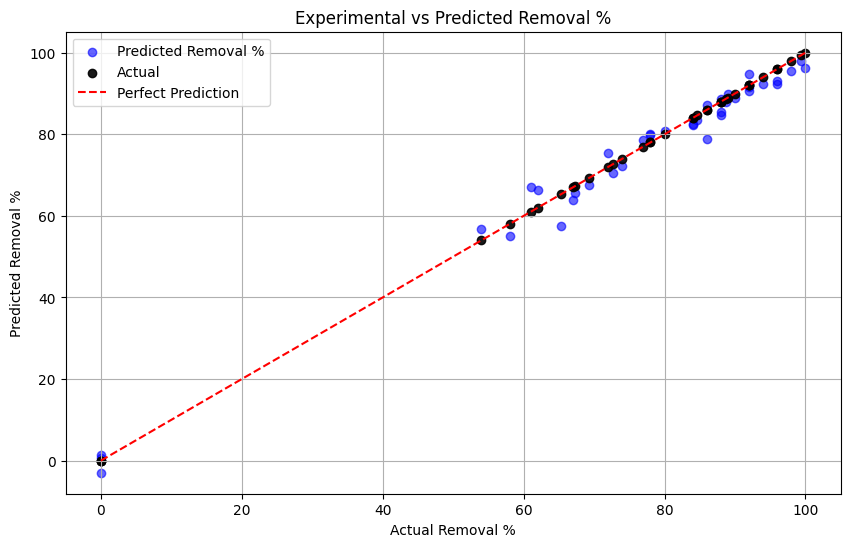

In [ ]:
# Scatter plot of Experimental vs Predicted Removal % with regression line
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Convert y_test and y_pred to numerical type if they are not already
y_test_num = y_test.astype(float)  # Convert to float if necessary
y_pred_num = y_pred.astype(float)  # Convert to float if necessary

plt.scatter(y_test_num, y_pred_num, alpha=0.6, color='b', label='Predicted Removal %')
plt.scatter(y_test_num, y_test_num, alpha=0.9, color='black', label='Actual')
plt.plot([min(y_test_num), max(y_test_num)], [min(y_test_num), max(y_test_num)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Removal %')
plt.ylabel('Predicted Removal %')
plt.title('Experimental vs Predicted Removal %')
plt.legend()
plt.grid(True)
plt.show()

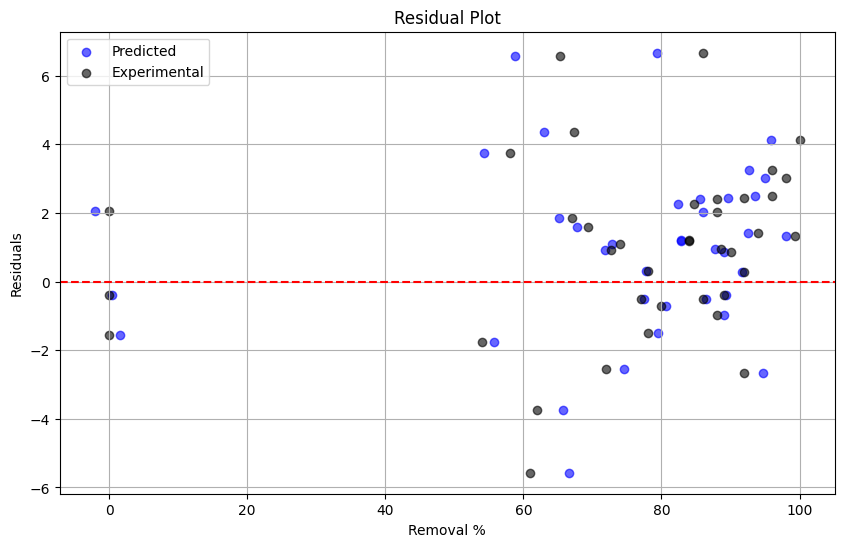

In [ ]:
# Residual plot with predicted and experimental Removal (%)
residuals = y_test.astype(float) - y_pred  # Convert y_test to float before subtraction
plt.figure(figsize=(10, 6))

# Blue dots for predicted Removal (%)
plt.scatter(y_pred, residuals, alpha=0.6, color='b', label='Predicted')

# Black dots for experimental Removal (%)
plt.scatter(y_test.astype(float), residuals, alpha=0.6, color='k', label='Experimental') # Also convert here for consistency

# Horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel('Removal %')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# prompt: import sns

!pip install seaborn
import seaborn as sns


Bagging

In [ ]:
# prompt: Perform Bagging on the dataset where the target is 'Rem' and others are the feature. Measure the performance based on R squared, MSE, MAE, Median Absolute Error.

from sklearn.ensemble import BaggingRegressor

# Separate features and target
X = df1.drop('Rem', axis=1)
y = df1['Rem']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the BaggingRegressor model
model = BaggingRegressor(
    base_estimator=HistGradientBoostingRegressor(),
    n_estimators=100,
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)

print("R squared:", r2)
print("MSE:", mse)
print("MAE:", mae)
print("Median Absolute Error:", median_ae)


R squared: 0.988483814340532
MSE: 7.197372303159188
MAE: 2.1359300783640225
Median Absolute Error: 1.667825293951097


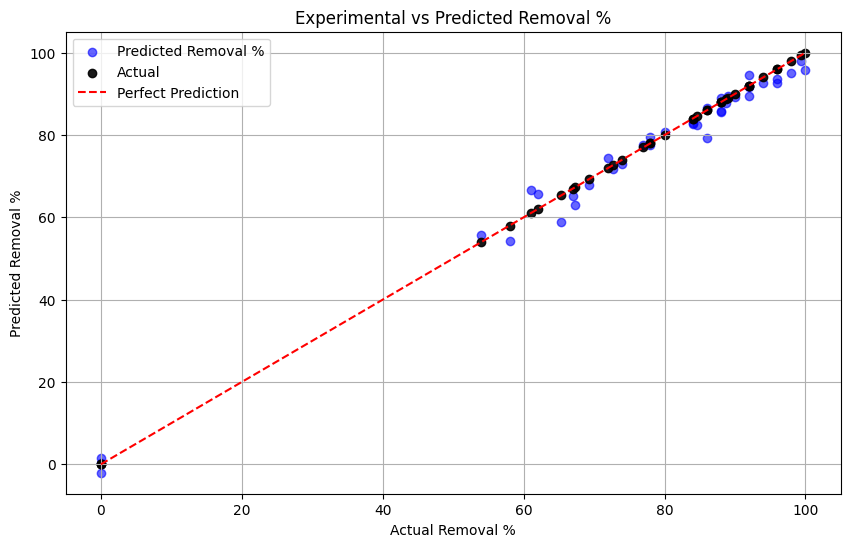

In [ ]:
# Scatter plot of Experimental vs Predicted Removal % with regression line
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Convert y_test and y_pred to numerical type if they are not already
y_test_num = y_test.astype(float)  # Convert to float if necessary
y_pred_num = y_pred.astype(float)  # Convert to float if necessary

plt.scatter(y_test_num, y_pred_num, alpha=0.6, color='b', label='Predicted Removal %')
plt.scatter(y_test_num, y_test_num, alpha=0.9, color='black', label='Actual')
plt.plot([min(y_test_num), max(y_test_num)], [min(y_test_num), max(y_test_num)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Removal %')
plt.ylabel('Predicted Removal %')
plt.title('Experimental vs Predicted Removal %')
plt.legend()
plt.grid(True)
plt.show()

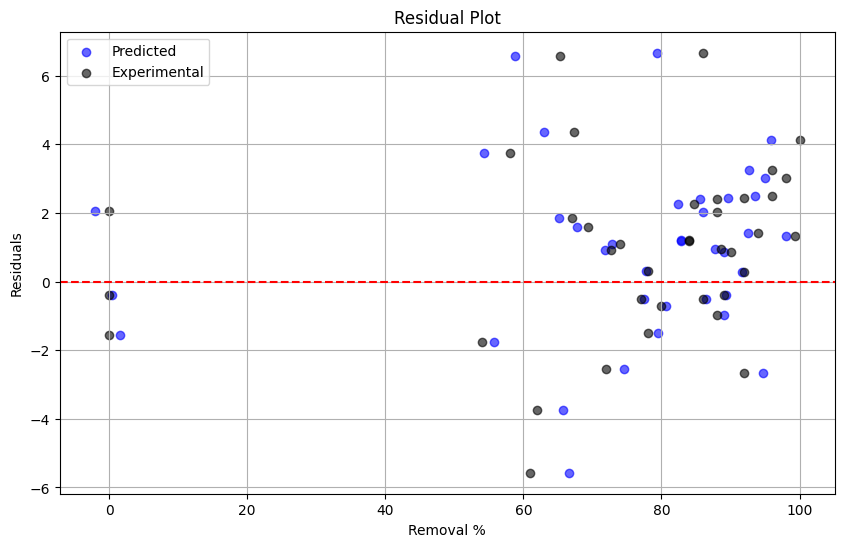

In [ ]:
# Residual plot with predicted and experimental Removal (%)
residuals = y_test.astype(float) - y_pred  # Convert y_test to float before subtraction
plt.figure(figsize=(10, 6))

# Blue dots for predicted Removal (%)
plt.scatter(y_pred, residuals, alpha=0.6, color='b', label='Predicted')

# Black dots for experimental Removal (%)
plt.scatter(y_test.astype(float), residuals, alpha=0.6, color='k', label='Experimental') # Also convert here for consistency

# Horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel('Removal %')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)
plt.show()

Adaboost

In [ ]:
# prompt: Perform AdaBoost on the dataset where the target is 'Rem' and others are the feature. Measure the performance based on R squared, MSE, MAE, Median Absolute Error.

from sklearn.ensemble import AdaBoostRegressor

# Separate features and target
X = df1.drop('Rem', axis=1)
y = df1['Rem']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the AdaBoostRegressor model
model = AdaBoostRegressor(
    base_estimator=HistGradientBoostingRegressor(),
    n_estimators=100,
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)

print("R squared:", r2)
print("MSE:", mse)
print("MAE:", mae)
print("Median Absolute Error:", median_ae)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


R squared: 0.9910178237463954
MSE: 5.613670055469973
MAE: 1.873417007245645
Median Absolute Error: 1.8620645479915225


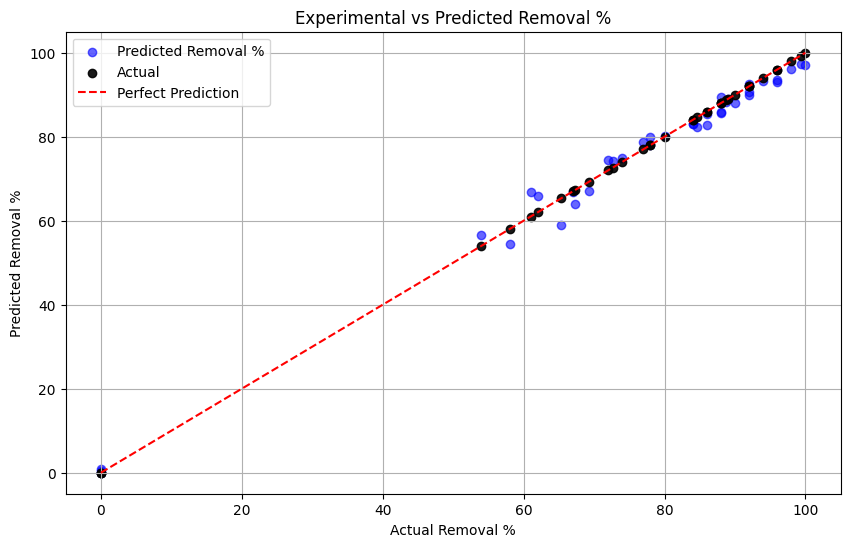

In [ ]:
# Scatter plot of Experimental vs Predicted Removal % with regression line
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Convert y_test and y_pred to numerical type if they are not already
y_test_num = y_test.astype(float)  # Convert to float if necessary
y_pred_num = y_pred.astype(float)  # Convert to float if necessary

plt.scatter(y_test_num, y_pred_num, alpha=0.6, color='b', label='Predicted Removal %')
plt.scatter(y_test_num, y_test_num, alpha=0.9, color='black', label='Actual')
plt.plot([min(y_test_num), max(y_test_num)], [min(y_test_num), max(y_test_num)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Removal %')
plt.ylabel('Predicted Removal %')
plt.title('Experimental vs Predicted Removal %')
plt.legend()
plt.grid(True)
plt.show()

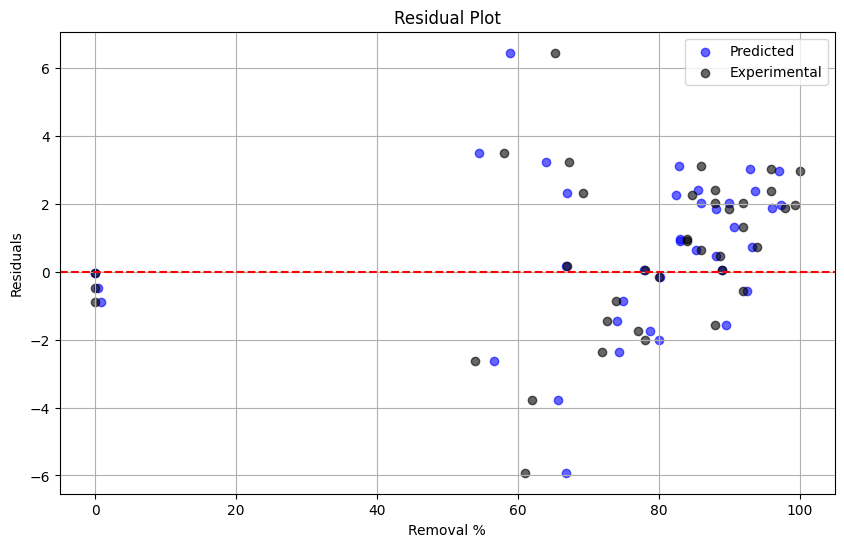

In [ ]:
# Residual plot with predicted and experimental Removal (%)
residuals = y_test.astype(float) - y_pred  # Convert y_test to float before subtraction
plt.figure(figsize=(10, 6))

# Blue dots for predicted Removal (%)
plt.scatter(y_pred, residuals, alpha=0.6, color='b', label='Predicted')

# Black dots for experimental Removal (%)
plt.scatter(y_test.astype(float), residuals, alpha=0.6, color='k', label='Experimental') # Also convert here for consistency

# Horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel('Removal %')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)
plt.show()

RandomForest

In [ ]:
# prompt: Perform \RandomForest on the dataset where the target is 'Rem' and others are the feature. Measure the performance based on R squared, MSE, MAE, Median Absolute Error.

# Separate features and target
X = df1.drop('Rem', axis=1)
y = df1['Rem']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the RandomForestRegressor model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)

print("R squared:", r2)
print("MSE:", mse)
print("MAE:", mae)
print("Median Absolute Error:", median_ae)


R squared: 0.992090689238603
MSE: 4.943151829473685
MAE: 1.461342105263157
Median Absolute Error: 0.8295999999999992


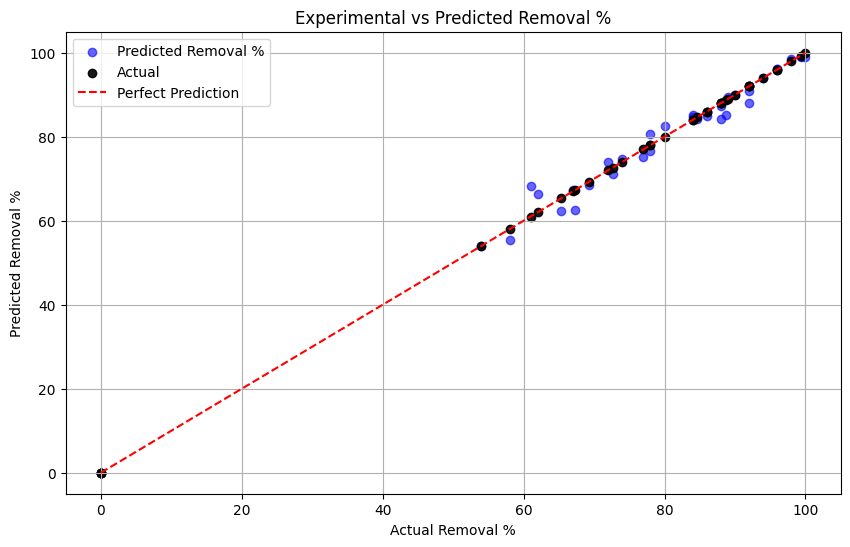

In [ ]:
# Scatter plot of Experimental vs Predicted Removal % with regression line
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Convert y_test and y_pred to numerical type if they are not already
y_test_num = y_test.astype(float)  # Convert to float if necessary
y_pred_num = y_pred.astype(float)  # Convert to float if necessary

plt.scatter(y_test_num, y_pred_num, alpha=0.6, color='b', label='Predicted Removal %')
plt.scatter(y_test_num, y_test_num, alpha=0.9, color='black', label='Actual')
plt.plot([min(y_test_num), max(y_test_num)], [min(y_test_num), max(y_test_num)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Removal %')
plt.ylabel('Predicted Removal %')
plt.title('Experimental vs Predicted Removal %')
plt.legend()
plt.grid(True)
plt.show()

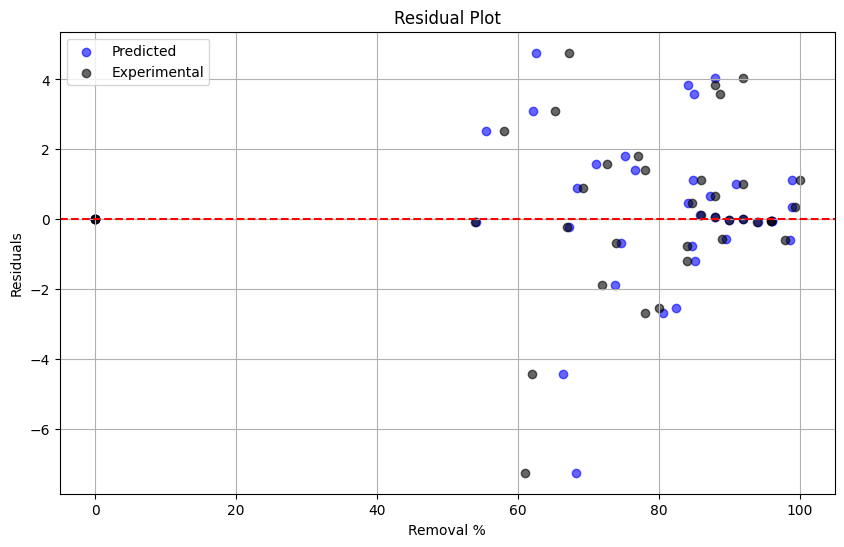

In [ ]:
# Residual plot with predicted and experimental Removal (%)
residuals = y_test.astype(float) - y_pred  # Convert y_test to float before subtraction
plt.figure(figsize=(10, 6))

# Blue dots for predicted Removal (%)
plt.scatter(y_pred, residuals, alpha=0.6, color='b', label='Predicted')

# Black dots for experimental Removal (%)
plt.scatter(y_test.astype(float), residuals, alpha=0.6, color='k', label='Experimental') # Also convert here for consistency

# Horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel('Removal %')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)
plt.show()

GradientBoosting

In [ ]:
# prompt: Perform GradientBoosting on the dataset where the target is 'Rem' and others are the feature. Measure the performance based on R squared, MSE, MAE, Median Absolute Error.

# Separate features and target
X = df1.drop('Rem', axis=1)
y = df1['Rem']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the GradientBoostingRegressor model
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)

print("R squared:", r2)
print("MSE:", mse)
print("MAE:", mae)
print("Median Absolute Error:", median_ae)


R squared: 0.9909367520984071
MSE: 5.664338119623852
MAE: 1.6416179619683406
Median Absolute Error: 1.0373312579168683


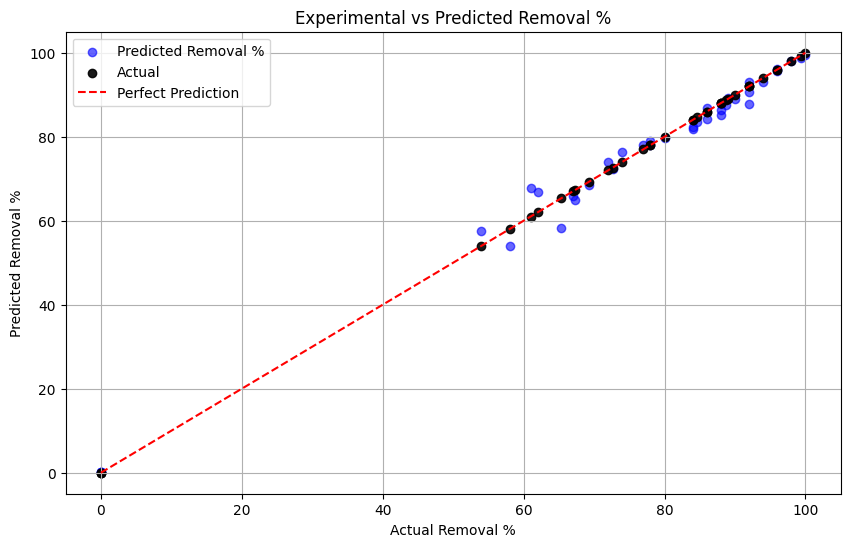

In [ ]:
# Scatter plot of Experimental vs Predicted Removal % with regression line
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Convert y_test and y_pred to numerical type if they are not already
y_test_num = y_test.astype(float)  # Convert to float if necessary
y_pred_num = y_pred.astype(float)  # Convert to float if necessary

plt.scatter(y_test_num, y_pred_num, alpha=0.6, color='b', label='Predicted Removal %')
plt.scatter(y_test_num, y_test_num, alpha=0.9, color='black', label='Actual')
plt.plot([min(y_test_num), max(y_test_num)], [min(y_test_num), max(y_test_num)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Removal %')
plt.ylabel('Predicted Removal %')
plt.title('Experimental vs Predicted Removal %')
plt.legend()
plt.grid(True)
plt.show()

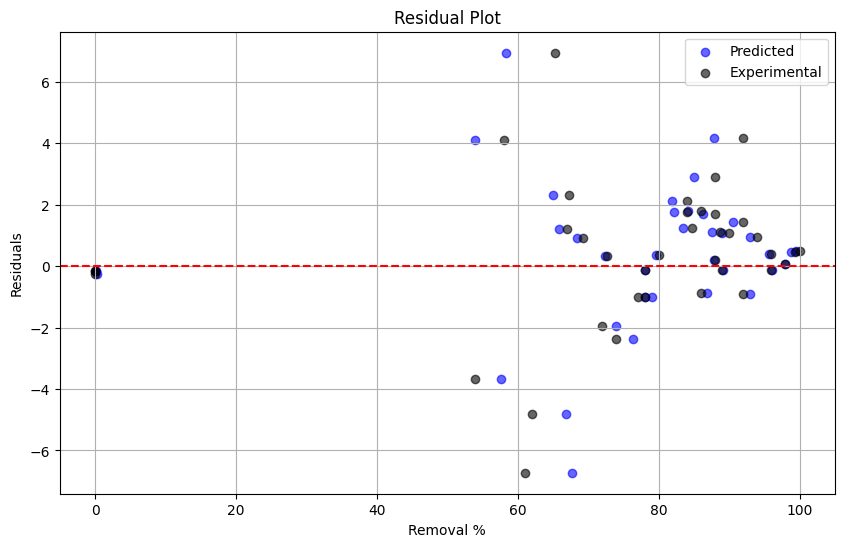

In [ ]:
# Residual plot with predicted and experimental Removal (%)
residuals = y_test.astype(float) - y_pred  # Convert y_test to float before subtraction
plt.figure(figsize=(10, 6))

# Blue dots for predicted Removal (%)
plt.scatter(y_pred, residuals, alpha=0.6, color='b', label='Predicted')

# Black dots for experimental Removal (%)
plt.scatter(y_test.astype(float), residuals, alpha=0.6, color='k', label='Experimental') # Also convert here for consistency

# Horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel('Removal %')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)
plt.show()

Extratree

In [ ]:
# prompt: Perform ExtraTree on the dataset where the target is 'Rem' and others are the feature. Measure the performance based on R squared, MSE, MAE, Median Absolute Error.

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error

# Separate features and target
X = df1.drop('Rem', axis=1)
y = df1['Rem']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the ExtraTreesRegressor model
model = ExtraTreesRegressor()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)

print("R squared:", r2)
print("MSE:", mse)
print("MAE:", mae)
print("Median Absolute Error:", median_ae)


R squared: 0.9967294279558919
MSE: 2.04403830763158
MAE: 0.8882236842105243
Median Absolute Error: 0.41244999999998555


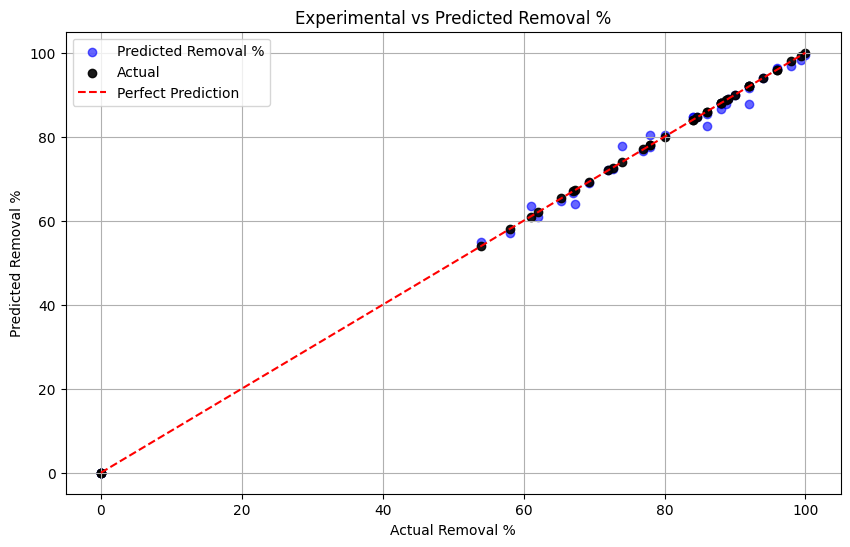

In [ ]:
# Scatter plot of Experimental vs Predicted Removal % with regression line
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Convert y_test and y_pred to numerical type if they are not already
y_test_num = y_test.astype(float)  # Convert to float if necessary
y_pred_num = y_pred.astype(float)  # Convert to float if necessary

plt.scatter(y_test_num, y_pred_num, alpha=0.6, color='b', label='Predicted Removal %')
plt.scatter(y_test_num, y_test_num, alpha=0.9, color='black', label='Actual')
plt.plot([min(y_test_num), max(y_test_num)], [min(y_test_num), max(y_test_num)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Removal %')
plt.ylabel('Predicted Removal %')
plt.title('Experimental vs Predicted Removal %')
plt.legend()
plt.grid(True)
plt.show()

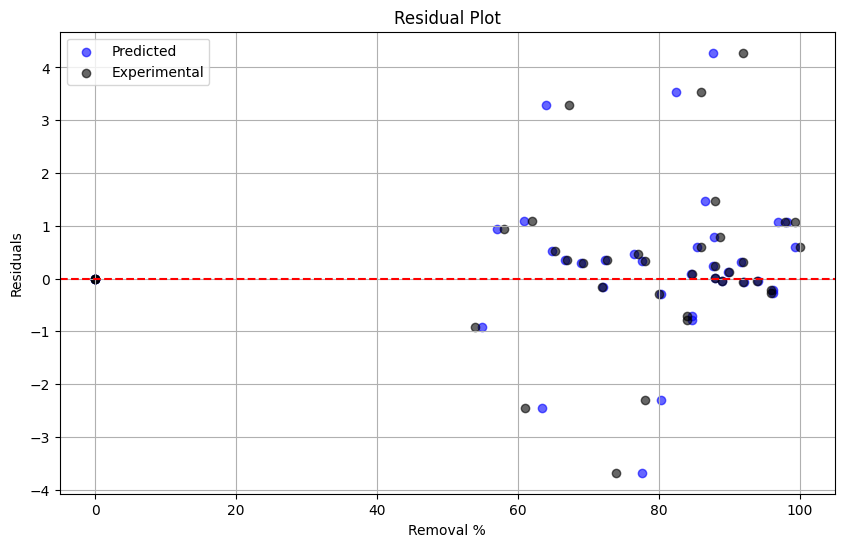

In [ ]:
# Residual plot with predicted and experimental Removal (%)
residuals = y_test.astype(float) - y_pred  # Convert y_test to float before subtraction
plt.figure(figsize=(10, 6))

# Blue dots for predicted Removal (%)
plt.scatter(y_pred, residuals, alpha=0.6, color='b', label='Predicted')

# Black dots for experimental Removal (%)
plt.scatter(y_test.astype(float), residuals, alpha=0.6, color='k', label='Experimental') # Also convert here for consistency

# Horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel('Removal %')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)
plt.show()

DecisionTree

In [ ]:
# prompt: Perform DecisionTree on the dataset where the target is 'Rem' and others are the feature. Measure the performance based on R squared, MSE, MAE, Median Absolute Error.

# Separate features and target
X = df1.drop('Rem', axis=1)
y = df1['Rem']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the DecisionTreeRegressor model
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)

print("R squared:", r2)
print("MSE:", mse)
print("MAE:", mae)
print("Median Absolute Error:", median_ae)


R squared: 0.9806632904611096
MSE: 12.085034210526317
MAE: 2.0792105263157894
Median Absolute Error: 1.0


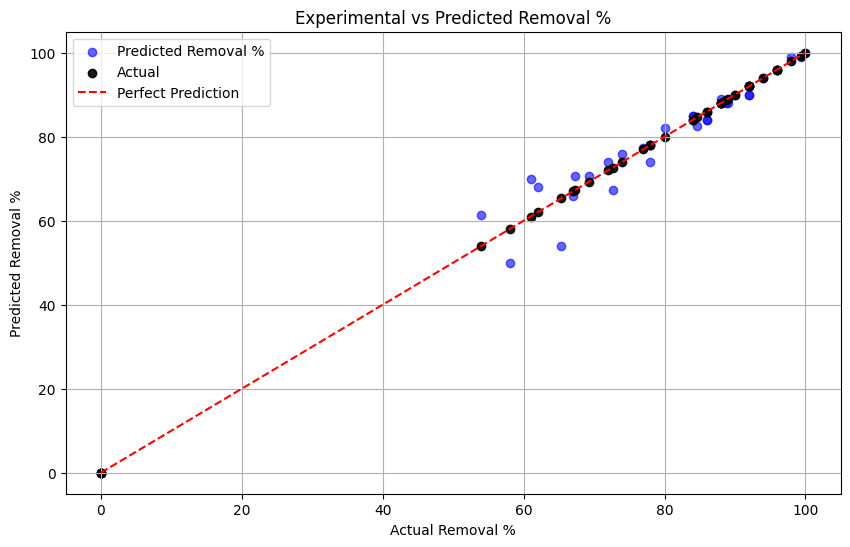

In [ ]:
# Scatter plot of Experimental vs Predicted Removal % with regression line
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Convert y_test and y_pred to numerical type if they are not already
y_test_num = y_test.astype(float)  # Convert to float if necessary
y_pred_num = y_pred.astype(float)  # Convert to float if necessary

plt.scatter(y_test_num, y_pred_num, alpha=0.6, color='b', label='Predicted Removal %')
plt.scatter(y_test_num, y_test_num, alpha=0.9, color='black', label='Actual')
plt.plot([min(y_test_num), max(y_test_num)], [min(y_test_num), max(y_test_num)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Removal %')
plt.ylabel('Predicted Removal %')
plt.title('Experimental vs Predicted Removal %')
plt.legend()
plt.grid(True)
plt.show()

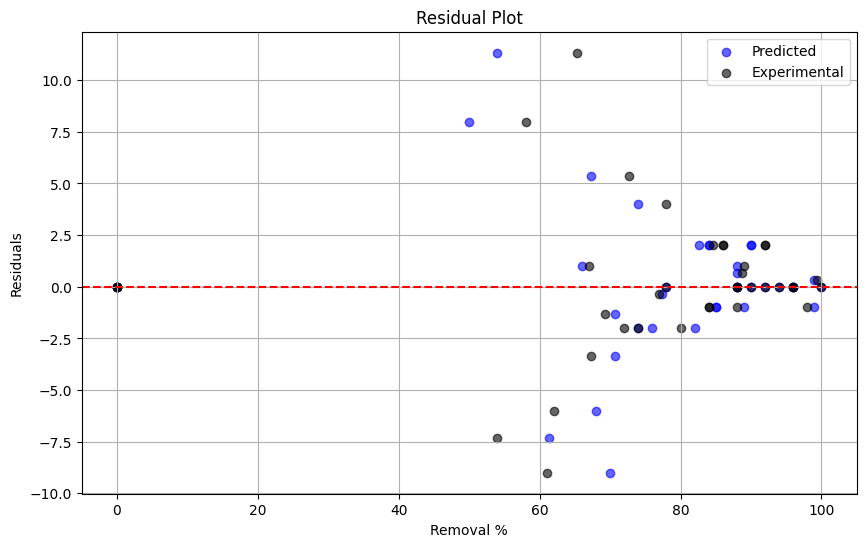

In [ ]:
# Residual plot with predicted and experimental Removal (%)
residuals = y_test.astype(float) - y_pred  # Convert y_test to float before subtraction
plt.figure(figsize=(10, 6))

# Blue dots for predicted Removal (%)
plt.scatter(y_pred, residuals, alpha=0.6, color='b', label='Predicted')

# Black dots for experimental Removal (%)
plt.scatter(y_test.astype(float), residuals, alpha=0.6, color='k', label='Experimental') # Also convert here for consistency

# Horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel('Removal %')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)
plt.show()

XGBoost

In [ ]:
# prompt: Perform XGboost on the dataset where the target is 'Rem' and others are the feature. Measure the performance based on R squared, MSE, MAE, Median Absolute Error.

from xgboost import XGBRegressor

# Separate features and target
X = df1.drop('Rem', axis=1)
y = df1['Rem']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
model = XGBRegressor()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)

print("R squared:", r2)
print("MSE:", mse)
print("MAE:", mae)
print("Median Absolute Error:", median_ae)


R squared: 0.9932346267985578
MSE: 4.228215065338316
MAE: 1.4507778823199242
Median Absolute Error: 0.9210968017578125


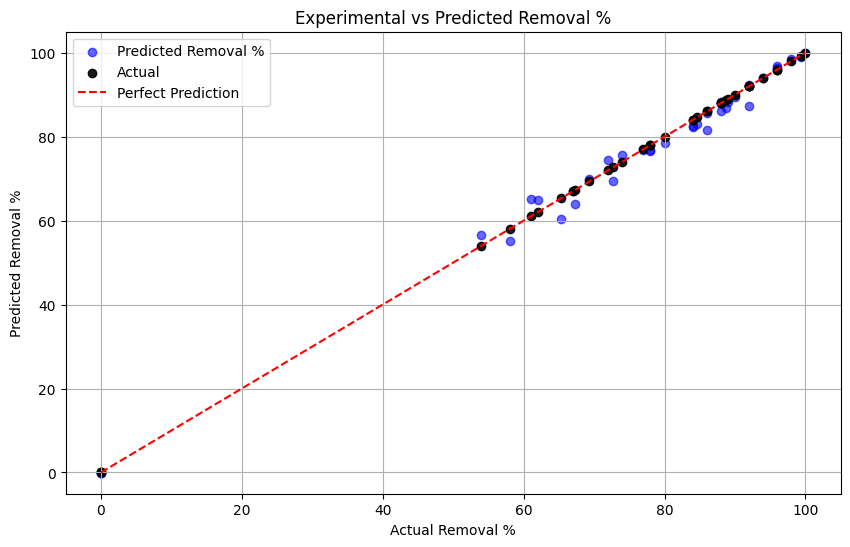

In [ ]:
# Scatter plot of Experimental vs Predicted Removal % with regression line
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Convert y_test and y_pred to numerical type if they are not already
y_test_num = y_test.astype(float)  # Convert to float if necessary
y_pred_num = y_pred.astype(float)  # Convert to float if necessary

plt.scatter(y_test_num, y_pred_num, alpha=0.6, color='b', label='Predicted Removal %')
plt.scatter(y_test_num, y_test_num, alpha=0.9, color='black', label='Actual')
plt.plot([min(y_test_num), max(y_test_num)], [min(y_test_num), max(y_test_num)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Removal %')
plt.ylabel('Predicted Removal %')
plt.title('Experimental vs Predicted Removal %')
plt.legend()
plt.grid(True)
plt.show()

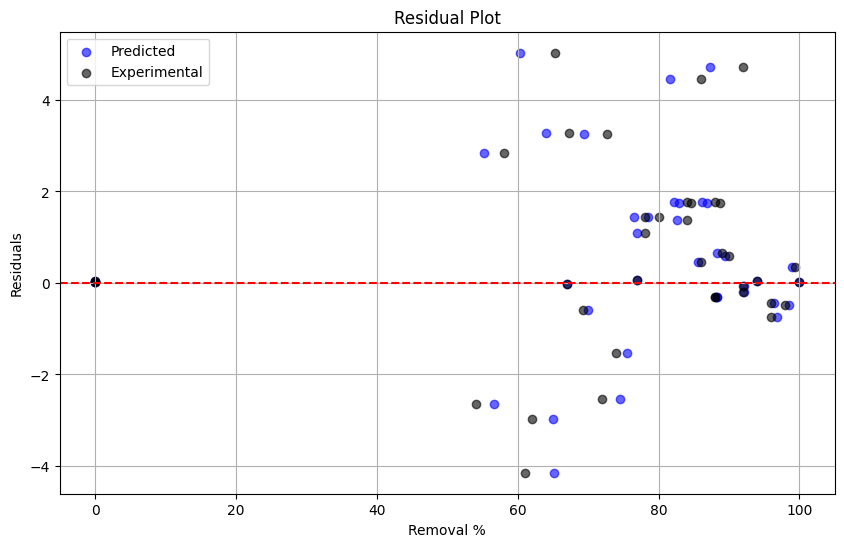

In [ ]:
# Residual plot with predicted and experimental Removal (%)
residuals = y_test.astype(float) - y_pred  # Convert y_test to float before subtraction
plt.figure(figsize=(10, 6))

# Blue dots for predicted Removal (%)
plt.scatter(y_pred, residuals, alpha=0.6, color='b', label='Predicted')

# Black dots for experimental Removal (%)
plt.scatter(y_test.astype(float), residuals, alpha=0.6, color='k', label='Experimental') # Also convert here for consistency

# Horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel('Removal %')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)
plt.show()

LightBoost

In [ ]:
# prompt: Perform LightBoost on the dataset where the target is 'Rem' and others are the feature. Measure the performance based on R squared, MSE, MAE, Median Absolute Error.

# Separate features and target
X = df1.drop('Rem', axis=1)
y = df1['Rem']

# Convert the target variable to numeric type
y = pd.to_numeric(y, errors='coerce') # Handle potential errors in conversion

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the LightGBM model
import lightgbm as lgb

model = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42
)

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)

print("R squared:", r2)
print("MSE:", mse)
print("MAE:", mae)
print("Median Absolute Error:", median_ae)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 5
[LightGBM] [Info] Start training from score 64.615828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

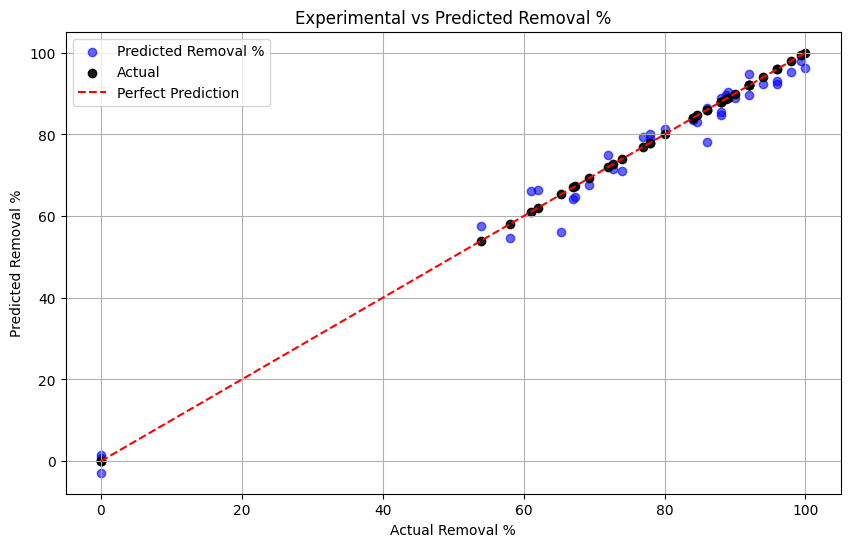

In [ ]:
# Scatter plot of Experimental vs Predicted Removal % with regression line
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Convert y_test and y_pred to numerical type if they are not already
y_test_num = y_test.astype(float)  # Convert to float if necessary
y_pred_num = y_pred.astype(float)  # Convert to float if necessary

plt.scatter(y_test_num, y_pred_num, alpha=0.6, color='b', label='Predicted Removal %')
plt.scatter(y_test_num, y_test_num, alpha=0.9, color='black', label='Actual')
plt.plot([min(y_test_num), max(y_test_num)], [min(y_test_num), max(y_test_num)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Removal %')
plt.ylabel('Predicted Removal %')
plt.title('Experimental vs Predicted Removal %')
plt.legend()
plt.grid(True)
plt.show()

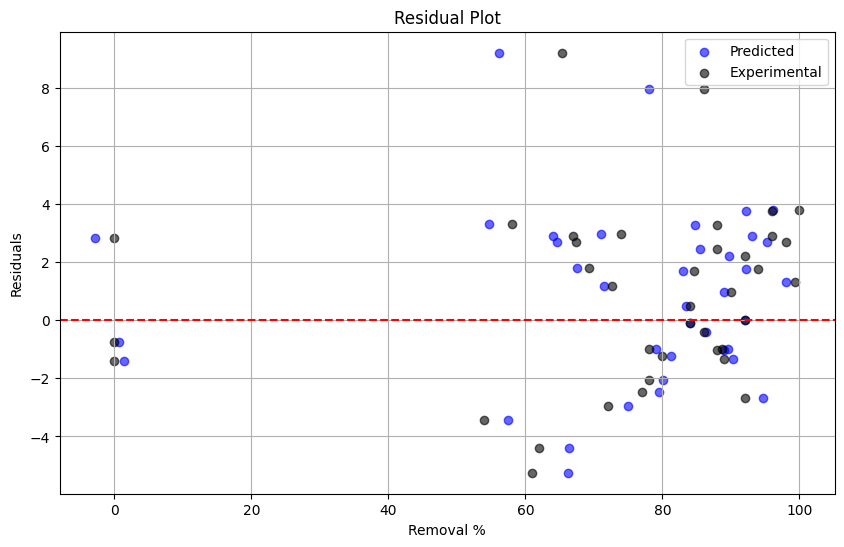

In [ ]:
# Residual plot with predicted and experimental Removal (%)
residuals = y_test.astype(float) - y_pred  # Convert y_test to float before subtraction
plt.figure(figsize=(10, 6))

# Blue dots for predicted Removal (%)
plt.scatter(y_pred, residuals, alpha=0.6, color='b', label='Predicted')

# Black dots for experimental Removal (%)
plt.scatter(y_test.astype(float), residuals, alpha=0.6, color='k', label='Experimental') # Also convert here for consistency

# Horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel('Removal %')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)
plt.show()

CatBoost

In [ ]:
# prompt: install catboost module

!pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.9 MB/s eta 0:00:00


In [ ]:
# prompt: Perform CatBoost on the dataset where the target is 'Rem' and others are the feature. Measure the performance based on R squared, MSE, MAE, Median Absolute Error.

import catboost as cb

# Separate features and target
X = df1.drop('Rem', axis=1)
y = df1['Rem']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the CatBoost model
model = cb.CatBoostRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42
)

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)

print("R squared:", r2)
print("MSE:", mse)
print("MAE:", mae)
print("Median Absolute Error:", median_ae)


0:	learn: 30.5097786	total: 56.6ms	remaining: 5.61s
1:	learn: 28.4050413	total: 64.4ms	remaining: 3.15s
2:	learn: 26.4002720	total: 67.6ms	remaining: 2.19s
3:	learn: 24.4749933	total: 74.8ms	remaining: 1.8s
4:	learn: 22.9048423	total: 79.5ms	remaining: 1.51s
5:	learn: 21.5458875	total: 84.5ms	remaining: 1.32s
6:	learn: 19.8015893	total: 88.8ms	remaining: 1.18s
7:	learn: 18.5887531	total: 104ms	remaining: 1.2s
8:	learn: 17.4668589	total: 111ms	remaining: 1.13s
9:	learn: 16.2424456	total: 113ms	remaining: 1.02s
10:	learn: 15.1527795	total: 120ms	remaining: 968ms
11:	learn: 14.1432322	total: 122ms	remaining: 898ms
12:	learn: 13.4882398	total: 139ms	remaining: 929ms
13:	learn: 12.5230474	total: 141ms	remaining: 864ms
14:	learn: 11.8097969	total: 142ms	remaining: 802ms
15:	learn: 11.0346817	total: 143ms	remaining: 749ms
16:	learn: 10.3044903	total: 148ms	remaining: 722ms
17:	learn: 9.6174131	total: 150ms	remaining: 685ms
18:	learn: 9.0083033	total: 154ms	remaining: 655ms
19:	learn: 8.452726

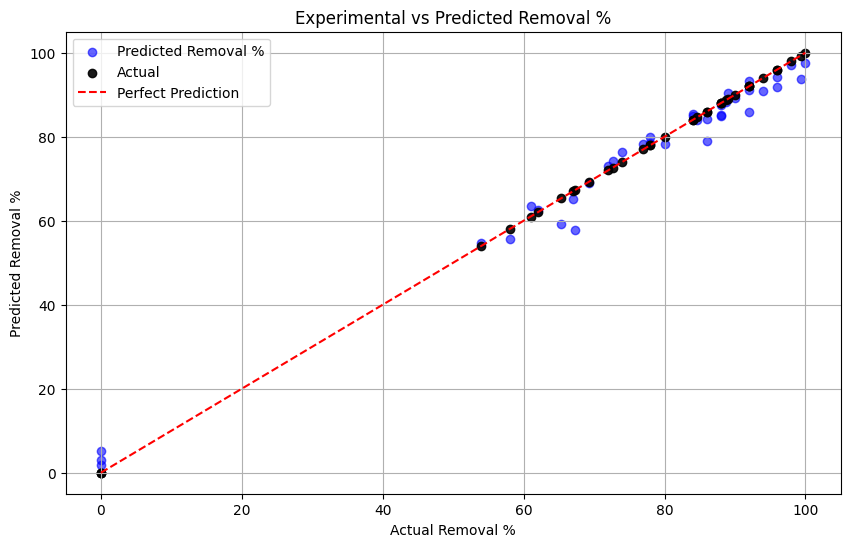

In [ ]:
# Scatter plot of Experimental vs Predicted Removal % with regression line
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Convert y_test and y_pred to numerical type if they are not already
y_test_num = y_test.astype(float)  # Convert to float if necessary
y_pred_num = y_pred.astype(float)  # Convert to float if necessary

plt.scatter(y_test_num, y_pred_num, alpha=0.6, color='b', label='Predicted Removal %')
plt.scatter(y_test_num, y_test_num, alpha=0.9, color='black', label='Actual')
plt.plot([min(y_test_num), max(y_test_num)], [min(y_test_num), max(y_test_num)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Removal %')
plt.ylabel('Predicted Removal %')
plt.title('Experimental vs Predicted Removal %')
plt.legend()
plt.grid(True)
plt.show()

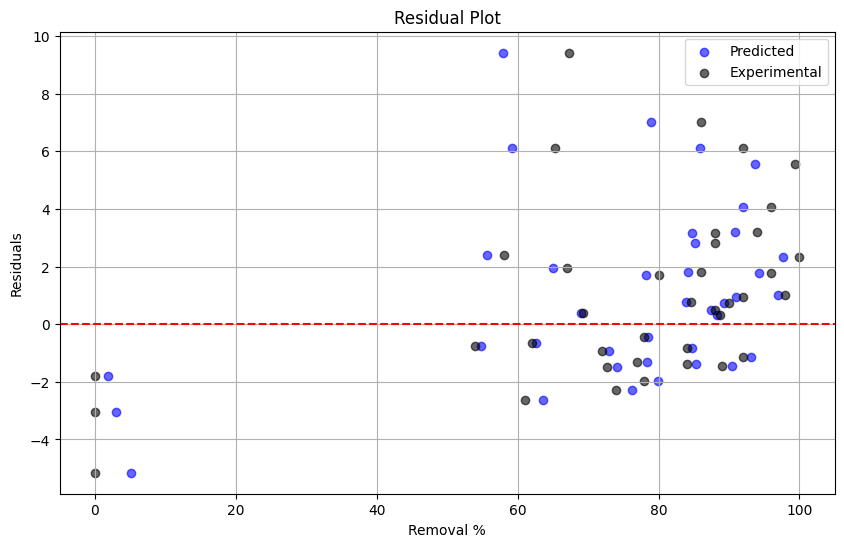

In [ ]:
# Residual plot with predicted and experimental Removal (%)
residuals = y_test.astype(float) - y_pred  # Convert y_test to float before subtraction
plt.figure(figsize=(10, 6))

# Blue dots for predicted Removal (%)
plt.scatter(y_pred, residuals, alpha=0.6, color='b', label='Predicted')

# Black dots for experimental Removal (%)
plt.scatter(y_test.astype(float), residuals, alpha=0.6, color='k', label='Experimental') # Also convert here for consistency

# Horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel('Removal %')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)
plt.show()

Ensemble

In [ ]:
# Prepare the features and target
X = df1.drop(columns=['Rem'], axis=1)
y = df1['Rem']

# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the search space for hyperparameters
search_spaces = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 20),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20)
}

# Initialize the models with Bayesian optimization
opt_rf = BayesSearchCV(estimator=RandomForestRegressor(), search_spaces=search_spaces, n_iter=32, cv=3, random_state=42, n_jobs=-1)
opt_gbr = BayesSearchCV(estimator=GradientBoostingRegressor(), search_spaces=search_spaces, n_iter=32, cv=3, random_state=42, n_jobs=-1)

# Fit the base models
opt_rf.fit(x_train, y_train)
opt_gbr.fit(x_train, y_train)

# Get the best models
model1 = opt_rf.best_estimator_
model2 = opt_gbr.best_estimator_

# Generate base model predictions on training and testing data
base_pred_train1 = model1.predict(x_train)[:, np.newaxis]
base_pred_train2 = model2.predict(x_train)[:, np.newaxis]
base_pred_test1 = model1.predict(x_test)[:, np.newaxis]
base_pred_test2 = model2.predict(x_test)[:, np.newaxis]

# Create stacked features for training and testing data
x_train_stacked = np.concatenate((x_train, base_pred_train1, base_pred_train2), axis=1)
x_test_stacked = np.concatenate((x_test, base_pred_test1, base_pred_test2), axis=1)

# Define and train the meta-model
meta_model = LinearRegression()
meta_model.fit(x_train_stacked, y_train)

# Make final predictions on the testing set using the stacked features
y_pred = meta_model.predict(x_test_stacked)

# Evaluate performance using mean squared error (MSE), mean absolute error (MAE), and R-squared
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R-squared:", r2)
print("Median Absolute Error:", median_ae)


MSE: 3.5696214711600813
MAE: 1.3699735085973435
R-squared: 0.9942884122337455
Median Absolute Error: 0.9530294911875714


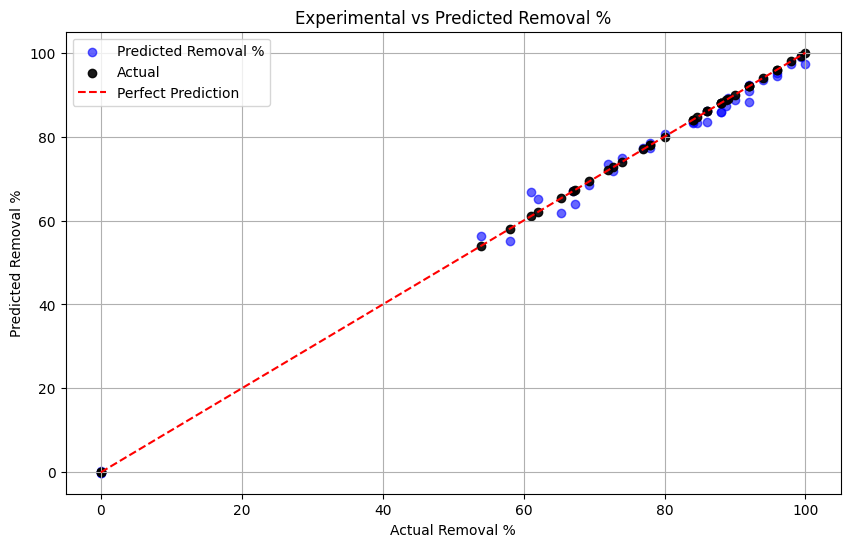

In [ ]:
# Scatter plot of Experimental vs Predicted Removal % with regression line
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Convert y_test and y_pred to numerical type if they are not already
y_test_num = y_test.astype(float)  # Convert to float if necessary
y_pred_num = y_pred.astype(float)  # Convert to float if necessary

plt.scatter(y_test_num, y_pred_num, alpha=0.6, color='b', label='Predicted Removal %')
plt.scatter(y_test_num, y_test_num, alpha=0.9, color='black', label='Actual')
plt.plot([min(y_test_num), max(y_test_num)], [min(y_test_num), max(y_test_num)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Removal %')
plt.ylabel('Predicted Removal %')
plt.title('Experimental vs Predicted Removal %')
plt.legend()
plt.grid(True)
plt.show()

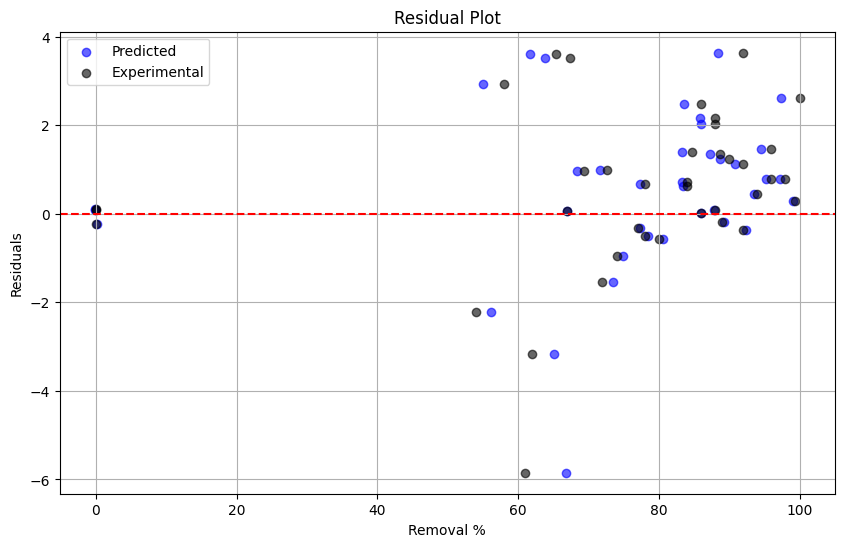

In [ ]:
# Residual plot with predicted and experimental Removal (%)
residuals = y_test.astype(float) - y_pred  # Convert y_test to float before subtraction
plt.figure(figsize=(10, 6))

# Blue dots for predicted Removal (%)
plt.scatter(y_pred, residuals, alpha=0.6, color='b', label='Predicted')

# Black dots for experimental Removal (%)
plt.scatter(y_test.astype(float), residuals, alpha=0.6, color='k', label='Experimental') # Also convert here for consistency

# Horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel('Removal %')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df1.columns

Index(['ICMB', 'CD', 'LI', 'Time', 'FCMB', 'Rem'], dtype='object')

In [ ]:
!pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.5 MB/s eta 0:00:00


In [ ]:
# prompt: install pdpbox

!pip install pdpbox


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: sphinx
    Found existing installation: Sphinx 5.0.2
    Uninstalling Sphinx-5.0.2:
      Successfully uninstalled Sphinx-5.0.2


In [ ]:
# prompt: Can you draw Two-factor partial dependence plots of removal (%) for any two important input parameters

import matplotlib.pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Separate features and target
X = df1.drop('Rem', axis=1)
y = df1['Rem']

# Train a model (e.g., RandomForestRegressor)
model = RandomForestRegressor()
model.fit(X, y)

# Choose two important input parameters
input_1 = 'ICMB'
input_2 = 'CD'

# Create the partial dependence plot
pdp_interact_plot(model, X, input_1, input_2, n_jobs=-1)

# Show the plot
plt.show()


ImportError: cannot import name 'get_dataset' from 'pdpbox' (/usr/local/lib/python3.10/dist-packages/pdpbox/__init__.py)

In [ ]:
import matplotlib.pyplot as plt
import shap

# Load JS visualization code to notebook
shap.initjs()

# Create explainers
explainer = shap.KernelExplainer(model.predict, X_train)

# Select two important input parameters
input_params = ['ICMB', 'CD']

# Create Two-factor partial dependence plot
# The interaction_index parameter is removed here
shap.partial_dependence_plot(input_params[0], model.predict, X_train, model_expected_value=True,
                             feature_expected_value=True, ice=False,
                             shap_values=explainer.shap_values(X_train),
                             features=X_train)

shap.partial_dependence_plot(input_params[1], model.predict, X_train, model_expected_value=True,
                             feature_expected_value=True, ice=False,
                             shap_values=explainer.shap_values(X_train),
                             features=X_train)
# Display the plot
plt.show()

  0%|          | 0/151 [00:00<?, ?it/s]

TypeError: partial_dependence() got an unexpected keyword argument 'features'

  0%|          | 0/151 [00:00<?, ?it/s]

TypeError: memoryview: invalid slice key

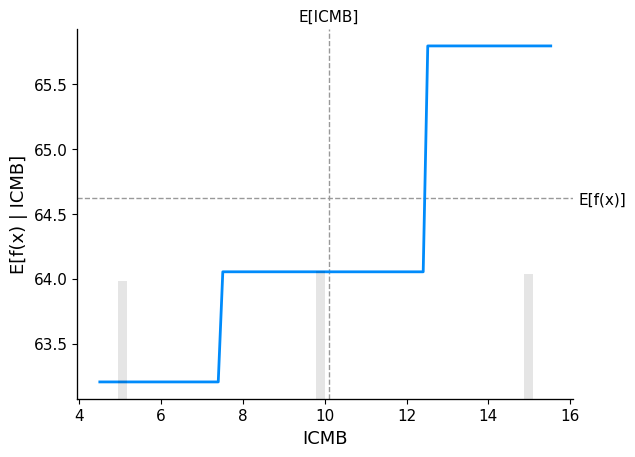

In [ ]:
import matplotlib.pyplot as plt
import shap

# Load JS visualization code to notebook
shap.initjs()

# Create explainers
explainer = shap.KernelExplainer(model.predict, X_train)

# Select two important input parameters
input_params = ['ICMB', 'CD']

# Create Two-factor partial dependence plot
# The interaction_index and features parameters are removed
shap.partial_dependence_plot(input_params[0], model.predict, X_train, model_expected_value=True,
                             feature_expected_value=True, ice=False,
                             shap_values=explainer.shap_values(X_train))

shap.partial_dependence_plot(input_params[1], model.predict, X_train, model_expected_value=True,
                             feature_expected_value=True, ice=False,
                             shap_values=explainer.shap_values(X_train))

# Display the plot
plt.show()

In [ ]:
!pip show shap

Name: shap
Version: 0.46.0
Summary: A unified approach to explain the output of any machine learning model.
Home-page: 
Author: 
Author-email: Scott Lundberg <slund1@cs.washington.edu>
License: MIT License
Location: /usr/local/lib/python3.10/dist-packages
Requires: cloudpickle, numba, numpy, packaging, pandas, scikit-learn, scipy, slicer, tqdm
Required-by: 


In [ ]:
df1.head()

,ICMB,CD,LI,Time,FCMB,Rem
0,5.0,100.0,20.0,0.0,5.0,0.0
1,5.0,100.0,20.0,15.0,1.3,74.0
2,5.0,100.0,20.0,30.0,0.8,84.0
3,5.0,100.0,20.0,45.0,0.6,88.0
4,5.0,100.0,20.0,60.0,0.4,92.0
